In [53]:
import os
import imp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import cvxpy as cp
from tqdm import tqdm
from utils import spectral_analysis,make_deviations,make_S_0,make_S_tilde,make_sens_ts
from measurements import constrained_linear_measurement_operator
import matrix_sensitivities as mat_sens
import opendssdirect as dss
imp.reload(mat_sens)

<module 'matrix_sensitivities' from '/home/sam/github/PowerSensitivities.jl/py/matrix_sensitivities.py'>

In [18]:
np.random.seed(2022)

In [16]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/123Bus/IEEE123Master.dss"
dss.run_command("compile "+path)

''

In [54]:
imp.reload(plt)
imp.reload(matplotlib)
imp.reload(sns)
sns.set_context("paper")
sns.set_theme(style="darkgrid")
plt.style.use("bmh")
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['legend.fontsize'] = 7
matplotlib.rcParams['lines.linewidth'] = 2

# Modeling Complex Power Injections in the IEEE 123-Bus Case using Voltage Sensitivities


## Load Training and Test Data:
### 1. Train Data: Real Hourly Varying Demand, Fixed Power Factor
A constant power factor of $\alpha_i = 0.9, i = 1,\dots,n$ is applied to all loads.

In [22]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/HourlyDemand_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
data = make_deviations((p,q,v))
(dx,dv) = data
svp,svq = sens['svp'],sens['svq']
S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (548, 23) (274, 23)


### 2. Test Data: Synthetic demands, fixed power factor 

In [23]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp_synth,dvdq_synth,p_synth,q_synth,v_synth = [pd.read_pickle(f).values for f in files]
sens_synth = make_sens_ts(dvdp_synth,dvdq_synth)
data_synth = make_deviations((p_synth,q_synth,v_synth))
(dx_synth,dv_synth) = data_synth

In [24]:
os.chdir("/home/sam/github/PowerSensitivities.jl/py/")

#### Initialize results dictionary and known coefficients.

In [28]:
#Results dictionary
S_hat_results = {}


### Standard Recovery Problem:
$$
\min || \Delta V - \tilde{S} \Delta X||_F^2 +  \lambda|| \tilde{S}||_*\\
\text{st} \quad ||\tilde{S_0} - \tilde{S}_{\Omega}||_F \leq \delta\\
$$

Parameters:
- $\lambda$, $\tilde{S}$ matrix low-rank penalty
- $\delta$ - known coefficient matching penalty

#### 45 pct precomputed coefficients

In [35]:
#Setup precomputed coefficients
pct_obs = 0.45 #Fix a 45% precomputed coefficient level
O_,S_0 = make_S_0(S_tilde,pct_obs)

#Setup variables
S = cp.Variable(S_0.shape) #Wide S decision matrix

#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
lamb_.value,delta_.value = 1.25e-3,1e-7

#Setup problem, solve, and save estimated matrix
prob = mat_sens.mat_rec_problem(S=S,S_0=S_0,dx=dx,dv=dv,lamb=lamb_,o=O_,delta=delta_)
prob.solve(verbose=True)
S_hat_results["standard"] = S.value

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 15 11:15:08 AM: Your problem has 150152 variables, 3 constraints, and 2 parameters.
(CVXPY) Apr 15 11:15:08 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 15 11:15:08 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 15 11:15:08 AM: Compiling problem (target solver=SCS).
(CVXPY) Apr 15 11:15:08 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 15 11:15:08 AM: Applying reduction Dcp2Cone
(CVXPY) Apr 15 11:15:08 AM: Applying reduction CvxAttr2Constr
(CVXPY

#### 1 pct precomputed coefficients

In [67]:
#Setup precomputed coefficients
pct_obs = 0.01 #Fix a 35% precomputed coefficient level
O_,S_0 = make_S_0(S_tilde,pct_obs)

#Setup variables
S = cp.Variable(S_0.shape) #Wide S decision matrix

#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
lamb_.value,delta_.value = 1.25e-3,1e-7

#Setup problem, solve, and save estimated matrix
prob = mat_sens.mat_rec_problem(S=S,S_0=S_0,dx=dx,dv=dv,lamb=lamb_,o=O_,delta=delta_)
prob.solve(verbose=True)
S_hat_results["standard_1pct"] = S.value

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 15 12:42:12 PM: Your problem has 150152 variables, 3 constraints, and 2 parameters.
(CVXPY) Apr 15 12:42:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 15 12:42:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 15 12:42:12 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 15 12:42:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 15 12:42:12 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 15 12:42:12 PM: Applying reduction CvxAttr2Constr
(CVXPY

/home/sam/anaconda3/envs/mohca/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [70]:
#April 15th 2022
#dump  results
import pickle
with open('sens_results/S_hat_results_lambd1e-3_delta1e-7.pickle', 'wb') as handle:
    pickle.dump(S_hat_results, handle, protocol=pickle.HIGHEST_PROTOCOL)



### Implicit Recovery Problem:
$$
\min || \Delta V - \tilde{S} \Delta X||_F^2 + ||\Delta V - (S_P^V + S_Q^V K)\Delta P||_F^2 + \lambda|| \tilde{S}||_*\\
\text{st} \quad ||\tilde{S_0} - \tilde{S}_{\Omega}||_F \leq \delta\\
$$

Parameters:
- $\lambda$, $\tilde{S}$ matrix low-rank penalty
- $\delta$ - known coefficient matching penalty
- $K$ - Matrix of implicit power factor representations


In [36]:
#Setup precomputed coefficients
pct_obs = 0.45 #Fix a 45% precomputed coefficient level
O_,S_0 = make_S_0(S_tilde,pct_obs)

#Setup variables
S = cp.Variable(S_0.shape) #Wide S decision matrix
pf = np.ones(S_0.shape[0])*0.9 #Constant 0.9 pf at all loads
K = mat_sens.K(pf) #implicit encoding matrix

#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
lamb_.value,delta_.value = 1.25e-3,1e-7

#Setup problem, solve, and save estimated matrix
prob = mat_sens.mat_rec_problem_implicit(S=S,S_0=S_0,K=K,dx=dx,dv=dv,lamb=lamb_,o=O_,delta=delta_)
prob.solve(verbose=True)
S_hat_results["implicit"] = S.value

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 15 11:19:23 AM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 15 11:19:23 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 15 11:19:23 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 15 11:19:23 AM: Compiling problem (target solver=SCS).
(CVXPY) Apr 15 11:19:23 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 15 11:19:23 AM: Applying reduction Dcp2Cone
(CVXPY) Apr 15 11:19:23 AM: Applying reduction CvxAttr2Constr
(CVXPY

### Rectangular Recovery Problem:
$$
\min || \Delta V - \tilde{S} \Delta X||_F^2 + \lambda_p|| S_P^V||_* + \lambda_q ||S_Q^V||_*\\
\text{st} \quad ||\tilde{S_0} - \tilde{S}_{\Omega}||_F \leq \delta\\
$$

Parameters:
- $\lambda_p$, svp matrix low-rank penalty
- $\lambda_q$, svq matrix low-rank penalty
- $\delta$ - known coefficient matching penalty


In [27]:
#Setup precomputed coefficients
pct_obs = 0.45 #Fix a 45% precomputed coefficient level
O_,S_0 = make_S_0(S_tilde,pct_obs)

#Setup variables
S = cp.Variable(S_0.shape)

#Setup parameters
p_lamb_,q_lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
p_lamb_.value,q_lamb_.value,delta_.value = 1.25e-2,1.25e-3,1e-7

#Setup problem, solve, and save estimated matrix
prob = mat_sens.mat_rec_problem_rect_nuc(S=S,S_0=S_0,dx=dx,dv=dv,p_lamb=p_lamb_,q_lambd=q_lamb_,o=O_,delta=delta_)
prob.solve(verbose=True)
S_hat_results["rectangular"] = S.value

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 15 10:54:15 AM: Your problem has 150152 variables, 4 constraints, and 3 parameters.
(CVXPY) Apr 15 10:54:15 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 15 10:54:15 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 15 10:54:15 AM: Compiling problem (target solver=SCS).
(CVXPY) Apr 15 10:54:15 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 15 10:54:15 AM: Applying reduction Dcp2Cone
(CVXPY) Apr 15 10:54:15 AM: Applying reduction CvxAttr2Constr
(CVXPY

0.7214839901117456

### Print results for each method

In [41]:
for key,S_hat in S_hat_results.items():
    print(key)
    err=mat_sens.calc_rel_err(M_hat=S_hat,M=S_tilde)*100
    print("Rel pct err: {err}".format(err=err))


rectangular
Rel pct err: 3.577908717400428
implicit
Rel pct err: 3.2389865189727836
standard
Rel pct err: 3.0329758669225884


### Plot the results for the Standard Method

Text(0.5, 0.98, 'IEEE 123-Bus $\\tilde{\\mathbf{S}}$ Recovery, $\\alpha=0.9$')

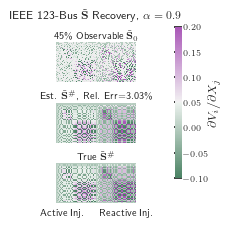

In [66]:

S_hat = S_hat_results['standard']
fig,axes = plt.subplots(nrows=3,
                            figsize=(3.5,3.5/1.61828),
                            constrained_layout=True,
                            sharex=True, sharey=True)

#Colorbar axis and cmap
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
cbar_ax = fig.add_axes([.725, .2, .02, .7])
cbar_ax.tick_params(labelsize=6,pad=0.5)
cbar_ax.get_yaxis().labelpad = -1

#cbar_ax.set_label(r"$\partial V_i \big/ \partial X_j$",pad=-1)
cbar_kws = {
    'label':r"$\partial V_i \big/ \partial X_j$",
    'fraction':0.05,
    'shrink':15,
    'pad':-10}


rel_err = mat_sens.calc_rel_err(M_hat=S_hat,M=S_tilde)*100

#Plot observed matrix
#Include colorbar on first heatmap
axes[0] = sns.heatmap(np.asarray(S_0),ax=axes[0],
                        cmap=cmap,cbar=True,vmin=-0.1,vmax=0.2,
                        cbar_ax=cbar_ax,cbar_kws=cbar_kws,
                        square=True,xticklabels=False,yticklabels=False,
                        mask=(np.asarray(S_0)==0),
                       )

axes[0].set_title(r"{pct_obs:.0f}\%".format(pct_obs=pct_obs*100) + r" Observable $\tilde{\mathbf{S}}_0$",fontsize=7,pad=3)

#Plot recovered matrix
axes[1] = sns.heatmap(S_hat,ax=axes[1],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False
                     )

axes[1].set_title(r"Est. $\tilde{\mathbf{S}}^{\#}$,"+" Rel. Err={rel_err:.2f}\%".format(rel_err=rel_err),fontsize=7,pad=3)

#Plot true matrix
axes[2] = sns.heatmap(S_tilde,ax=axes[2],
                      cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                      square=True,xticklabels=False,yticklabels=False
                     )

axes[2].set_title(r"True $\tilde{\mathbf{S}}^{\#}$",fontsize=7,pad=3)
axes[2].set_xlabel(r"\ \ \ Active Inj. \quad Reactive Inj.",fontsize=7)

#Figure-level formatting
plt.suptitle(r"IEEE 123-Bus $\tilde{\mathbf{S}}$ Recovery, $\alpha=0.9$",fontsize=8)
#fig.tight_layout(rect=[0, 0, .85, 1])

## Solve the Matrix recovery problem with different hyperparameters 

In [ ]:
lambd_values = np.linspace(start=1e-3,stop=1e-1,num=15) #From partially -> highly prioritizing low rank solutions
delta_values = [0,1e-3,1e-2,1e-1,1] # From no disobedience of the precomputed coefficients allowed ->some allowed

### Sweep over grid of parameters and see effect of parameters on results

In [11]:
#Save a few sensitivity matrices every 5 iterations to show the effect of the parameters
S_hats = []
results = [] #results for this grid
for i,l in tqdm(enumerate(lambd_values),desc='lambd vals'):
    for d in delta_values:
        #Set hyperparams
        lamb_.value,delta_.value = l,d
        #Solve problem
        prob.solve(verbose=True if i ==0 else False)
        #Store results
        results.append({
            'lambd':l,'delta':d,
            'dv_train_rel_err':mat_sens.calc_rel_err(S.value@dx,dv)*100,
            'dv_test_rel_err':mat_sens.calc_rel_err(S.value@dx_synth,dv_synth)*100,
            'S_rel_err':mat_sens.calc_rel_err(S.value,S_tilde)*100
        })
        if(np.mod(i,5) == 0): #Save a few sensitivity matrices every 5 iterations to show the effect of the parameters
            S_hats.append({
                'S':S.value,
                'lambd':l,
                'delta':d,
                'dv_train_rel_err':mat_sens.calc_rel_err(S.value@dx,dv)*100,
                'dv_test_rel_err':mat_sens.calc_rel_err(S.value@dx_synth,dv_synth)*100,
                'S_rel_err':mat_sens.calc_rel_err(S.value,S_tilde)*100
            })

lambd vals: 0it [00:00, ?it/s]

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Apr 13 01:19:56 PM: Your problem has 150152 variables, 2 constraints, and 2 parameters.
(CVXPY) Apr 13 01:19:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 13 01:19:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 13 01:19:56 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 13 01:19:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 13 01:19:56 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 13 01:19:56 PM: Applying reduction CvxAttr2Constr
(CVXPY

lambd vals: 15it [1:46:41, 426.75s/it]


In [12]:
##Dump current results

# import pickle
# with open('py/sens_results/err_results_lambd1e-3_to_1e-1_delta0_to_1.pickle', 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('S_hats_lambd1e-3_to_1e-1_delta0_to_1.pickle', 'wb') as handle:
#     pickle.dump(S_hats, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Load current results
import pickle
#Tight range err results
with open('sens_results/err_results_lambd1e-3_to_1e-1_delta0_to_1.pickle', 'rb') as handle:
    results = pickle.load(handle)
#Tight range S_hats
with open('sens_results/S_hats_lambd1e-3_to_1e-1_delta0_to_1.pickle', 'rb') as handle:
    S_hats = pickle.load(handle)
#Wide range err results    
with open('sens_results/err_results_wide_range.pickle', 'rb') as handle:
    wide_range_results = pickle.load(handle)
#Wide range S_hats
with open('sens_results/S_hats_wide_range.pickle', 'rb') as handle:
    wide_range_S_hats = pickle.load(handle)

### Plot the results of the $\tilde{\mathbf{S}}^{\#}$ matrix and errors vs. choice of $\lambda$ and $\delta$

In [13]:
df1 = pd.DataFrame.from_dict(wide_range_results[0])
df2 = pd.DataFrame.from_dict(wide_range_results[1])
df3 = pd.DataFrame.from_dict(results)
df_wide_range = pd.concat((df1,df2),ignore_index=True)

In [15]:
df_full = pd.concat((df3[df3["delta"]!=1],df_wide_range[(df_wide_range["delta"]<=1) & (df_wide_range["lambd"]<=0.1)]),ignore_index=True)
df_full

,lambd,delta,dv_train_rel_err,dv_test_rel_err,S_rel_err
0,0.001000,0.000000,0.019085,6.086880,2.817597
1,0.001000,0.001000,0.019111,6.090579,2.814566
2,0.001000,0.010000,0.018538,6.072383,2.778311
3,0.001000,0.100000,0.015740,5.985924,2.608376
4,0.008071,0.000000,0.063595,6.156693,2.340384
...,...,...,...,...,...
99,0.100000,0.004642,0.170646,6.227664,3.818837
100,0.100000,0.010000,0.170160,6.226579,3.818165
101,0.100000,0.021544,0.169306,6.224806,3.818342
102,0.100000,0.046416,0.167971,6.222371,3.823395


<AxesSubplot:xlabel='lambd', ylabel='dv_test_rel_err'>

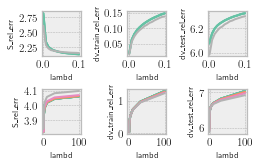

In [17]:
fig,axes = plt.subplots(
    figsize=(3.5,3.5/1.61828),constrained_layout=True,
    nrows=2,ncols=3
)
axes[0,0] = sns.lineplot(
    #data=df_full,
    data=df3[df3["delta"]!=1],
    x="lambd",y="S_rel_err",
    hue="delta",
    palette=sns.color_palette("Set2",as_cmap=True),
    ax=axes[0,0],legend=False
)
axes[0,1] = sns.lineplot(
    #data=df_full,
    data=df3[df3["delta"]!=1],
    x="lambd",y="dv_train_rel_err",
    hue="delta",
    palette=sns.color_palette("Set2",as_cmap=True),
    ax=axes[0,1],legend=False,
    label="Train Set"
)
axes[0,2] = sns.lineplot(
    #data=df_full,
    data=df3[df3["delta"]!=1],
    x="lambd",y="dv_test_rel_err",
    hue="delta",
    palette=sns.color_palette("Set2",as_cmap=True),
    ax=axes[0,2],legend=False,
    label="Test Set"
)

axes[1,0] = sns.lineplot(
    data=df_wide_range,
    x="lambd",y="S_rel_err",
    hue="delta",
    palette=sns.color_palette("Set2",as_cmap=True),
    ax=axes[1,0],legend=False
)
sns.lineplot(
    data=df_wide_range,
    x="lambd",y="dv_train_rel_err",
    hue="delta",
    palette=sns.color_palette("Set2",as_cmap=True),
    ax=axes[1,1],legend=False,
    label="Train Set"
)
sns.lineplot(
    data=df_wide_range,
    x="lambd",y="dv_test_rel_err",
    hue="delta",
    palette=sns.color_palette("Set2",as_cmap=True),
    ax=axes[1,2],legend=False,
    label="Test Set"
)

In [19]:
df_full[df_full["S_rel_err"] == df_full["S_rel_err"].min()]

,lambd,delta,dv_train_rel_err,dv_test_rel_err,S_rel_err
57,0.1,0.001,0.148385,6.321567,2.134042


In [150]:
svp[0].shape

(274, 274)

Study slice:  slice(50, 251, None)
DP_sliced:  (201, 23) DQ sliced:  (201, 23) DV sliced:  (201, 23)
(201, 402) (201, 402)
(402, 23) (201, 23)
Matrix relative error 71.91725455656497\%


<AxesSubplot:>

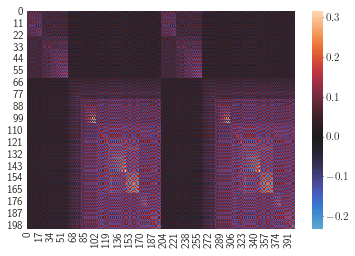

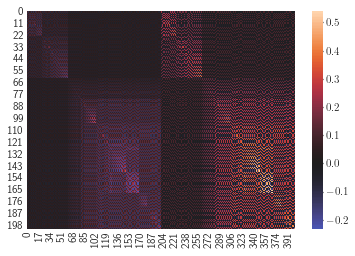

In [260]:
from sklearn.linear_model import MultiTaskElasticNetCV

#Make a study slice for the IEEE 123 bus feeder
def make_study_slice(study_idx,slice_range,n_features=S.shape[0]):
    """Make a study slice of the sensitivity matrices"""
    if(slice_range==0):
        study_slice = study_idx
        local_sp_idx = 0
        return study_slice,local_sp_idx
    else:
        if(study_idx==0):
            study_slice = np.s_[0:2*slice_range+1]
            local_sp_idx = 0
        elif(study_idx <= slice_range and slice_range>1):
            study_slice = np.s_[0:2*slice_range+1]
            local_sp_idx = study_idx
        elif(study_idx==n_features-1):
            study_slice = np.s_[n_features-2*slice_range:n_features]
            local_sp_idx = study_idx - (n_features-2*slice_range)
        elif(study_idx>=n_features-slice_range):
            study_slice = np.s_[n_features-2*slice_range:n_features]
            local_sp_idx = study_idx -(study_idx-slice_range) 
        else:
            study_slice = np.s_[study_idx-slice_range:study_idx+slice_range+1]
            local_sp_idx = slice_range
        return study_slice

def search(S_hats):
    """Search for the best result"""
    err = [el["S_rel_err"] for el in S_hats]
    print('total matrix rel err ',np.min(err))
    return [element for element in S_hats if element['S_rel_err'] == np.min(err)]

#Make study slice
study_slice = make_study_slice(150,100)
print("Study slice: ",study_slice)

#Slice the estimated S_tilde_hat over the study slice
n_bus = dv.shape[0]
S_hat = S.value
svp_hat,svq_hat = S_hat[:,:n_bus][study_slice,study_slice],S_hat[:,n_bus:][study_slice,study_slice]
sliced_S_hat = make_S_tilde(svp_hat,svp_hat)

#Make the ground truth S_tilde over the study slice
sliced_S_tilde = make_S_tilde(np.mean(svp,axis=0)[study_slice,study_slice],np.mean(svq,axis=0)[study_slice,study_slice])

#Slice the measurement data
(dp,dq,dv) = [np.diff(x) for x in (p,q,v)]
dp_sliced,dq_sliced,dv_sliced = dp[study_slice,:],dq[study_slice,:],dv[study_slice,:]

dx_sliced = np.vstack((dp_sliced,dq_sliced))

#Print the shapes
print("DP_sliced: ",dp_sliced.shape,"DQ sliced: ",dq_sliced.shape,"DV sliced: ",dv_sliced.shape)
print(sliced_S_hat.shape,sliced_S_tilde.shape)
print(dx_sliced.shape,dv_sliced.shape)

#Print the relative error of the estimated S_tilde
print("Matrix relative error {e}\%".format(e=mat_sens.calc_rel_err(M_hat=sliced_S_hat,M=sliced_S_tilde)*100))

sns.heatmap(sliced_S_hat,center=0)
plt.figure()
sns.heatmap(sliced_S_tilde,center=0)

In [261]:
dp.shape

(274, 23)

In [262]:
from sklearn.linear_model import LassoCV
hat_S_reg = LassoCV(
    max_iter=5e3,
    n_alphas=200,
    verbose=1,
    selection="random",
    n_jobs=-1, #Use all processors
    random_state=2022
)

gt_S_reg = LassoCV(
    max_iter=5e3,
    n_alphas=200,
    verbose=1,
    selection="random",
    n_jobs=-1, #Use all processors
    random_state=2022
)
#Study time index
t = 0
#Solve the complex power estimation with the estimated matrix
hat_S_reg.fit(sliced_S_hat,dv_sliced[:,t])
#Solve the complex power estimation with the true S_tilde
gt_S_reg.fit(sliced_S_tilde,dv_sliced[:,t])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(max_iter=5000.0, n_alphas=200, n_jobs=-1, random_state=2022,
        selection='random', verbose=1)

In [263]:
dx_hat_hat = hat_S_reg.coef_
dx_hat = gt_S_reg.coef_
dx_truth = dx_sliced[:,t]
print(dx_hat_hat.shape,dx_hat.shape,dx_truth.shape)

(402,) (402,) (402,)


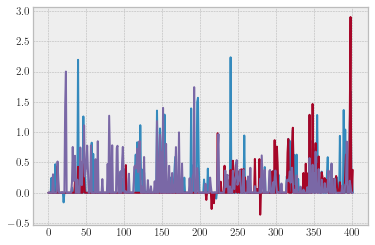

In [268]:
plt.plot(dx_hat_hat)
plt.plot(dx_hat)
plt.plot(dx_truth)

## Solve the Matrix recovery problem with different levels of precomputed local coefficients

In [14]:
#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
pct_obs_ = [0.1,0.2,0.3,0.4,0.5,0.75] #Different levels of sensitivities already known to the utility
results = []

In [163]:
#imp.reload(mat_sens)
for i,pct_obs in tqdm(enumerate(pct_obs_)):
    #S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
    S_tilde = make_S_tilde(svp[0],svq[0])
    O,S_0 = make_S_0(S_tilde,pct_obs)
    lamb_.value,delta_.value = 1.25e-1,6e-2
    #Solve problem
    S_hat,prob = mat_sens.mat_rec_solution(S_0,dx,dv,lamb=lamb_,o=O,delta=delta_)
    #Store results
    results.append({
        'pct_obs':pct_obs,
        'S_hat':S_hat.value,
        'prob':prob,
        'rel_err':mat_sens.calc_rel_err(S_hat.value,S_tilde)*100
    })

0it [00:00, ?it/s]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:37:13 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:37:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:37:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:37:13 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:37:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:37:13 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:37:13 PM: Applying reduction CvxAttr2Constr
(CVXPY

1it [03:19, 199.81s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:40:33 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:40:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:40:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:40:33 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:40:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:40:33 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:40:33 PM: Applying reduction CvxAttr2Constr
(CVXPY

2it [06:45, 203.17s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:43:59 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:43:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:43:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:43:59 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:43:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:43:59 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:43:59 PM: Applying reduction CvxAttr2Constr
(CVXPY

3it [10:15, 206.41s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:47:29 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:47:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:47:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:47:29 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:47:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:47:29 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:47:29 PM: Applying reduction CvxAttr2Constr
(CVXPY

4it [13:37, 204.47s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:50:51 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:50:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:50:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:50:51 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:50:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:50:51 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:50:51 PM: Applying reduction CvxAttr2Constr
(CVXPY

5it [16:28, 192.70s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:53:42 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:53:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:53:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:53:42 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:53:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:53:42 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:53:42 PM: Applying reduction CvxAttr2Constr
(CVXPY

6it [19:54, 199.14s/it]


In [166]:
mat_sens.calc_rel_err(S_hat.value,S_tilde)*100

1.012055777146652

Text(0.5, 1.0, '75% Observable Sensitivty Matrix (IEEE 123-bus)')

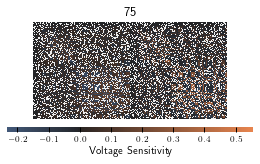

In [164]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_0),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_0)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)
ax.set_title("{pct_obs:.0f}% Observable Sensitivty Matrix (IEEE 123-bus)".format(pct_obs=pct_obs*100))

/tmp/ipykernel_935133/194154597.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .85, 1])


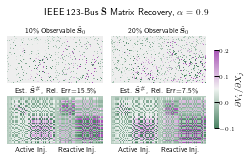

In [356]:
#Subplots
fig,axes = plt.subplots(nrows=2,ncols=2, 
                        figsize=(3.5,3.5/1.61828),
                        #constrained_layout=True,
                        sharex=True, sharey=True)

#Colorbar axis and cmap
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
cbar_ax = fig.add_axes([.85, .2, .02, .5])
cbar_ax.tick_params(labelsize=6,pad=0.5)
cbar_ax.get_yaxis().labelpad = -1
#cbar_ax.set_label(r"$\partial V_i \big/ \partial X_j$",pad=-1)
cbar_kws = {
    'label':r"$\partial V_i \big/ \partial X_j$",
    'fraction':0.05,
    'shrink':15,
    'pad':-10}


#First recovered matrix
pct_obs = results[1]['pct_obs']
rel_err = results[1]['rel_err']
O,S_0 = make_S_0(S_tilde,pct_obs)
#Include colorbar on first heatmap
axes[0,0] = sns.heatmap(np.asarray(S_0),ax=axes[0,0],
                        cmap=cmap,cbar=True,vmin=-0.1,vmax=0.2,
                        cbar_ax=cbar_ax,cbar_kws=cbar_kws,
                        square=True,xticklabels=False,yticklabels=False,
                        mask=(np.asarray(S_0)==0),
                       )
                        
axes[0,0].set_title(r"{pct_obs:.0f}\%".format(pct_obs=pct_obs*100) + r" Observable $\tilde{\mathbf{S}}_0$",fontsize=7,pad=3)
axes[1,0] = sns.heatmap(results[1]['S_hat'],ax=axes[1,0],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False)

axes[1,0].set_title(r"Est. $\tilde{\mathbf{S}}^{\#}$,"+" Rel. Err={rel_err:.1f}\%".format(rel_err=rel_err),fontsize=7,pad=3)
axes[1,0].set_xlabel(r"\ \ \ Active Inj. \quad Reactive Inj.",fontsize=7)

#Second recovered matrix
pct_obs = results[2]['pct_obs']
rel_err = results[2]['rel_err']
O,S_0 = make_S_0(S_tilde,pct_obs)
axes[0,1] = sns.heatmap(np.asarray(S_0),mask=(np.asarray(S_0)==0),ax=axes[0,1],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False)
axes[0,1].set_title(r"{pct_obs:.0f}\%".format(pct_obs=pct_obs*100) + r" Observable $\tilde{\mathbf{S}}_0$",fontsize=7,pad=3)
axes[1,1] = sns.heatmap(results[2]['S_hat'],ax=axes[1,1],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False)
axes[1,1].set_title(r"Est. $\tilde{\mathbf{S}}^{\#}$,"+" Rel. Err={rel_err:.1f}\%".format(rel_err=rel_err),fontsize=7,pad=3)
axes[1,1].set_xlabel(r"\ \ \ Active Inj. \quad  Reactive Inj.",fontsize=7)

#Figure-level formatting
plt.suptitle(r"IEEE 123-Bus $\tilde{\mathbf{S}}$ Matrix Recovery, $\alpha=0.9$",fontsize=9)
fig.tight_layout(rect=[0, 0, .85, 1])
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/IEE123_recovery_multi_lamb.125_delta.006.png",dpi=400)

### Compute the relative error time series (S matrix and voltage perturbations) for each observability level

In [172]:
import utils
for S_result in results:
    pct_obs = S_result["pct_obs"]
    S_hat = S_result["S_hat"]
    v_rel_err,  S_rel_err = [],[]
    for t,(dv_t,dx_t) in enumerate(zip(dv.T,dx.T)):
        hat_dv_t = S_hat@dx_t
        S_tilde = make_S_tilde(svp[t],svq[t])
        S_rel_err.append(mat_sens.calc_rel_err(S_hat,S_tilde)*100)
        v_rel_err.append(utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100)
    S_result["S_rel_err"] = S_rel_err
    S_result["v_rel_err"] = v_rel_err

### Plot the relative error time series

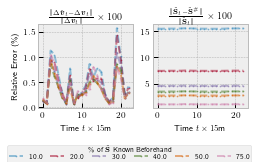

In [310]:
fig,axes = plt.subplots(ncols=2,figsize=(3.5,3.5/1.61828),
                        #constrained_layout=True,
                        sharex=True,sharey=False)
for S_result in results:
    pct_obs = S_result['pct_obs']
    if(pct_obs==0.01):
        continue
    v_rel_err,S_rel_err = S_result['v_rel_err'],S_result['S_rel_err']
    #Voltage relative error
    axes[0].plot(v_rel_err,'--o',label=str(pct_obs*100),alpha=0.5,markersize=0.8)
    #Sensitivity Matrix Relative Error
    axes[1].plot(S_rel_err,'--o',#label=str(pct_obs*100),
                 alpha=0.5,markersize=0.8)
    
#Voltage timeseries plot formatting
axes[0].set_title(r"$\frac{\| \Delta \hat{\boldsymbol{v}}_t - \Delta \boldsymbol{v}_t\|}{\| \Delta \boldsymbol{v}_t \|} \times 100$")
axes[0].set_xlabel(r"Time $t \times 15$m")
axes[0].set_ylabel("Relative Error (\%)")

#S matrix plot formatting
axes[1].set_title(r" $\frac{ \| \tilde{\mathbf{S}}_t - \tilde{\mathbf{S}}^{\#} \|}{\| \tilde{\mathbf{S}}_t \|} \times 100 $")
axes[1].set_xlabel(r"Time $t \times 15$m")

#Legend
fig.legend(fancybox=True,
           ncol=6,borderpad=0.25,labelspacing=1e-3,columnspacing=1.25,
           loc='lower center',borderaxespad=0.01,
           title=r"\% of $\tilde{\mathbf{S}}$ Known Beforehand",
           fontsize=7,title_fontsize=7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/rel_errs_ieee123.png",dpi=400)

## Plot the Full Matrix

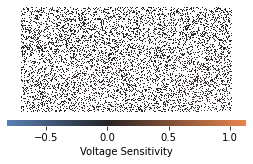

In [374]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_hat),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_hat)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)

## 3. Synthetic demands, varying power factor

In [487]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
data = make_deviations((p,q,v))
(dx,dv) = data
svp,svq = sens['svp'],sens['svq']
S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (548, 23) (274, 23)


In [517]:
os.chdir("/home/sam/github/PowerSensitivities.jl/py/")
import matrix_sensitivities as mat_sens
imp.reload(mat_sens)

<module 'matrix_sensitivities' from '/home/sam/github/PowerSensitivities.jl/py/matrix_sensitivities.py'>

In [518]:
#imp.reload(mat_sens)
#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
dx_,dv_ = cp.Parameter(dx.shape[0]),cp.Parameter(dv.shape[0])
pct_obs_ = [0.5,0.75] #Different levels of sensitivities already known to the utility
results = []
for i,pct_obs in tqdm(enumerate(pct_obs_)):
    #S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
    O,S_0 = make_S_0(S_tilde,pct_obs)
    lamb_.value,delta_.value = 1.25e-1,6e-2
    #Solve problem
    dv_.value,dx_.value= dv_t,dx_t #Set the voltage and power data parameters
    S_hat,prob = mat_sens.mat_rec_solution(S_0,dx_,dv_,lamb=lamb_,o=O,delta=delta_)
    #Store results
    results.append({
        'pct_obs':pct_obs,
        'S_hat':S_hat_series,
        'S_0':S_0,
        'prob':prob,
        'rel_err':mat_sens.calc_rel_err(S_hat.value,S_tilde)*100
    })

0it [00:00, ?it/s]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 10 05:23:16 PM: Your problem has 150152 variables, 2 constraints, and 824 parameters.
(CVXPY) Apr 10 05:23:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 10 05:23:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 10 05:23:16 PM: Compiling problem (target solver=DIFFCP).
(CVXPY) Apr 10 05:23:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> DIFFCP
(CVXPY) Apr 10 05:23:16 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 10 05:23:16 PM: Applying reduction CvxAttr2Const

1it [04:04, 244.04s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 10 05:27:20 PM: Your problem has 150152 variables, 2 constraints, and 824 parameters.
(CVXPY) Apr 10 05:27:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 10 05:27:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 10 05:27:20 PM: Compiling problem (target solver=DIFFCP).
(CVXPY) Apr 10 05:27:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> DIFFCP
(CVXPY) Apr 10 05:27:20 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 10 05:27:20 PM: Applying reduction CvxAttr2Const

2it [10:01, 300.65s/it]


In [523]:
lamb_.delta = 1e-2
delta_.delta = 1e-2
prob.derivative()

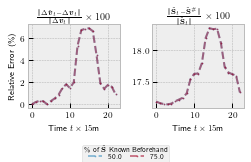

In [519]:
import utils
for S_result in results:
    pct_obs = S_result["pct_obs"]
    S_hat = S_result["S_hat"]
    v_rel_err,  S_rel_err = [],[]
    for t,(dv_t,dx_t) in enumerate(zip(dv.T,dx.T)):
        hat_dv_t = S_hat@dx_t
        S_tilde = make_S_tilde(svp[t],svq[t])
        S_rel_err.append(mat_sens.calc_rel_err(S_hat,S_tilde)*100)
        v_rel_err.append(utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100)
    S_result["S_rel_err"] = S_rel_err
    S_result["v_rel_err"] = v_rel_err
    

fig,axes = plt.subplots(ncols=2,figsize=(3.5,3.5/1.61828),
                        #constrained_layout=True,
                        sharex=True,sharey=False)
for S_result in results:
    pct_obs = S_result['pct_obs']
    if(pct_obs==0.01):
        continue
    v_rel_err,S_rel_err = S_result['v_rel_err'],S_result['S_rel_err']
    #Voltage relative error
    axes[0].plot(v_rel_err,'--o',label=str(pct_obs*100),alpha=0.5,markersize=0.8)
    #Sensitivity Matrix Relative Error
    axes[1].plot(S_rel_err,'--o',#label=str(pct_obs*100),
                 alpha=0.5,markersize=0.8)
    
#Voltage timeseries plot formatting
axes[0].set_title(r"$\frac{\| \Delta \hat{\boldsymbol{v}}_t - \Delta \boldsymbol{v}_t\|}{\| \Delta \boldsymbol{v}_t \|} \times 100$")
axes[0].set_xlabel(r"Time $t \times 15$m")
axes[0].set_ylabel("Relative Error (\%)")

#S matrix plot formatting
axes[1].set_title(r" $\frac{ \| \tilde{\mathbf{S}}_t - \tilde{\mathbf{S}}^{\#} \|}{\| \tilde{\mathbf{S}}_t \|} \times 100 $")
axes[1].set_xlabel(r"Time $t \times 15$m")

#Legend
fig.legend(fancybox=True,
           ncol=6,borderpad=0.25,labelspacing=1e-3,columnspacing=1.25,
           loc='lower center',borderaxespad=0.01,
           title=r"\% of $\tilde{\mathbf{S}}$ Known Beforehand",
           fontsize=7,title_fontsize=7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
#plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/vary_pf_rel_errs_ieee123.png",dpi=400)